In [2]:
# This code evolves the Einstein-Klein Gordon system of equations in the 3+1 decomposition 
# using the reference metric approach in arXiv:1211.6632
# to avoid coordinate singularities in the right hand side evolution
# Spherical symmetry is assumed and the outer boundary condition is 
# extrapolation at zeroth order

# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

# homemade code
from myparams import *                         # go here to change the grid and other params
from source.rhsevolution import *              # go here to look at how the evolution works
from source.mytests import *                   # go here to change the test conditions
from source.diagnostics import *               # go here to change the  diagnostics

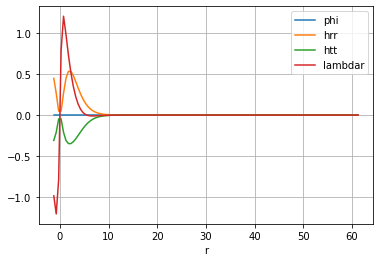

In [3]:
# This test sets up values such that R is known but phi = 0
initial_vars_values = get_test_vars_values_1()

#unpackage the vector for readability
initial_u   = initial_vars_values[idx_u * N : (idx_u + 1) * N]
initial_v   = initial_vars_values[idx_v * N : (idx_v + 1) * N]
initial_phi = initial_vars_values[idx_phi * N : (idx_phi + 1) * N]
#initial_chi = np.exp(-4.0*initial_phi)
initial_hrr = initial_vars_values[idx_hrr * N : (idx_hrr + 1) * N]
initial_htt = initial_vars_values[idx_htt * N : (idx_htt + 1) * N]
initial_lambdar = initial_vars_values[idx_lambdar * N : (idx_lambdar + 1) * N]

#plot initial conditions
plt.xlabel('r')
#plt.plot(r, initial_u, label='u')
#plt.plot(r, initial_v, label='v')
plt.plot(r, initial_phi, label='phi')
plt.plot(r, initial_hrr, label='hrr')
plt.plot(r, initial_htt, label='htt')
plt.plot(r, initial_lambdar, label='lambdar')
plt.legend(loc='best')
plt.grid()

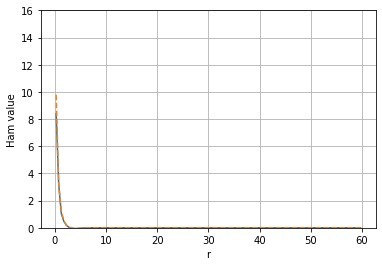

In [5]:
# calculate the diagnostics, the Ham constraint should just have 
# the term in bar_R so this tests the calculation of that quantity
Ham = get_diagnostics(initial_vars_values)
Ham_t = Ham[0][num_ghosts:(N-num_ghosts)]
r_diagnostics = r[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ham_t)

#analytic result for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
R_analytic = (1.0 / epowr * (epowr + x*x)**-3.0 
              * (8.0 * epowr * x**4.0 + 2.0 * x**6.0 
                 + epowr**3.0 * (16.0 - 9.0*x + x*x) 
                 - epowr**2.0 * x*x * (-14.0 + x + x*x)))


plt.plot(x, R_analytic, '--')

plt.xlabel('r')
plt.ylabel('Ham value')
plt.ylim(0,16)
plt.grid()

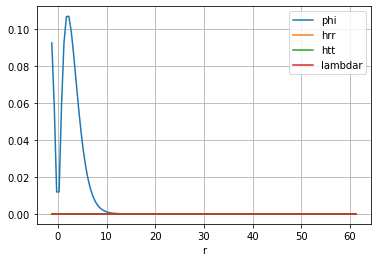

In [6]:
# This test sets up values such that R is known but bar_R = 0
initial_vars_values = get_test_vars_values_2()

#unpackage the vector for readability
initial_u   = initial_vars_values[idx_u * N : (idx_u + 1) * N]
initial_v   = initial_vars_values[idx_v * N : (idx_v + 1) * N]
initial_phi = initial_vars_values[idx_phi * N : (idx_phi + 1) * N]
#initial_chi = np.exp(-4.0*initial_phi)
initial_hrr = initial_vars_values[idx_hrr * N : (idx_hrr + 1) * N]
initial_htt = initial_vars_values[idx_htt * N : (idx_htt + 1) * N]
initial_lambdar = initial_vars_values[idx_lambdar * N : (idx_lambdar + 1) * N]

#plot initial conditions
plt.xlabel('r')
#plt.plot(r, initial_u, label='u')
#plt.plot(r, initial_v, label='v')
plt.plot(r, initial_phi, label='phi')
plt.plot(r, initial_hrr, label='hrr')
plt.plot(r, initial_htt, label='htt')
plt.plot(r, initial_lambdar, label='lambdar')
plt.legend(loc='best')
plt.grid()

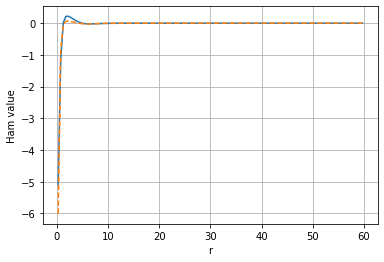

In [7]:
# calculate the diagnostics, the Ham constraint should just have 
# the terms in dphi, so this tests those, and Delta_U
Ham = get_diagnostics(initial_vars_values)
Ham_t = Ham[0][num_ghosts:(N-num_ghosts)]
r_diagnostics = r[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ham_t)

#analytic result for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
R_analytic = (0.5 * epowr * (epowr + x*x)**-3.0 
              * ( x*x * (12.0 - 12.0*x + x*x) 
                 - 4.0 * epowr * (6.0 - 6.0* x + x*x)))


plt.plot(x, R_analytic, '--')

plt.xlabel('r')
plt.ylabel('Ham value')
#plt.ylim(0,16)
plt.grid()